In [1]:
import gc
import pandas as pd
import numpy as np

#导入分析库
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import lightgbm as lgb
import xgboost as xgb
#!pip install catboost
import catboost as cat

from sklearn.metrics import roc_auc_score, roc_curve, auc
# LOCAL_QUICK = True
LOCAL_QUICK = False
sample_percent = 0.1

MORE_FE = False
# MORE_FE = True
FE_V1 = False if MORE_FE else True
gc.collect()

40

In [2]:
%%time
# 加载数据
# 用户行为，使用format1进行加载
user_log = pd.read_csv('user_log_format1.csv', dtype={'time_stamp':'str'})

user_info = pd.read_csv('user_info_format1.csv')

train_data1 = pd.read_csv('train_format1.csv')

sub_data = pd.read_csv('test_format1.csv')
data_train = pd.read_csv('train_format2.csv')
gc.collect()

CPU times: total: 1min
Wall time: 1min


0

In [3]:
%%time
# 采样测试
if LOCAL_QUICK:
    print('Local quick test: {}, rate is {}'.format(
        LOCAL_QUICK, sample_percent))
    data = user_log.sample(int(len(user_log) * sample_percent))
    data1 = user_info.sample(int(len(user_info) * sample_percent))
    data2 = train_data1.sample(int(len(train_data1) * sample_percent))
    # submission = sub_data.sample(int(len(sub_data) * sample_percent))
    submission = sub_data.copy()

else:
    print('All sample train')
    data = user_log.copy()
    data1 = user_info.copy()
    data2 = train_data1.copy()
    submission = sub_data.copy()
    del user_log, user_info, train_data1, sub_data
print('---data shape---')
for df in [data, data1, data2, submission, data_train]:
    print(df.shape)

All sample train
---data shape---
(54925330, 7)
(424170, 3)
(260864, 3)
(261477, 3)
(7030723, 6)
CPU times: total: 688 ms
Wall time: 704 ms


In [4]:
data2['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([data2, submission], ignore_index=True, sort=False)
matrix.drop(['prob'], axis=1, inplace=True)
# 连接user_info表，通过user_id关联
matrix = matrix.merge(data1, on='user_id', how='left')
# 使用merchant_id（原列名seller_id）
data.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [5]:
%%time
# 格式化
data['user_id'] = data['user_id'].astype('int32')
data['merchant_id'] = data['merchant_id'].astype('int32')
data['item_id'] = data['item_id'].astype('int32')
data['cat_id'] = data['cat_id'].astype('int32')
data['brand_id'].fillna(0, inplace=True)
data['brand_id'] = data['brand_id'].astype('int32')
data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%H%M')
# 缺失值填充
matrix['age_range'].fillna(0, inplace=True)
matrix['gender'].fillna(2, inplace=True)

# # gender用众数填充 表现更差
# matrix['gender'].fillna(matrix['gender'].mode()[0],inplace=True)
# # 年龄用中位数填充
# matrix['age_range'].fillna(matrix['age_range'].median(),inplace=True)

matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')

del data1, data2
gc.collect()

<timed exec>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to

CPU times: total: 9.33 s
Wall time: 9.39 s


5

In [6]:
%%time

##### 特征处理
##### User特征处理
groups = data.groupby(['user_id'])
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')
# 使用agg 基于列的聚合操作，统计唯一值个数 item_id, cat_id, merchant_id, brand_id
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
# 时间间隔特征 u6 按照小时
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计操作类型为0，1，2，3的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')

del temp
gc.collect()

CPU times: total: 32.2 s
Wall time: 32.6 s


19

In [7]:
%%time

##### 商家特征处理
groups = data.groupby(['merchant_id'])
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups[['user_id', 'item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(columns={
    'user_id':'m2',
    'item_id':'m3',
    'cat_id':'m4',
    'brand_id':'m5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

del temp
gc.collect()


CPU times: total: 15.9 s
Wall time: 16.2 s


0

In [8]:
# 按照merchant_id 统计随机负采样的个数
temp = data_train[data_train['label']==-1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [9]:
%%time
##### 用户+商户特征
groups = data.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups[['item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(columns={
    'item_id':'um2',
    'cat_id':'um3',
    'brand_id':'um4'
})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={
    0:'um5',
    1:'um6',
    2:'um7',
    3:'um8'
})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('frist', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['frist']).dt.seconds/3600
temp.drop(['frist', 'last'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

del temp
gc.collect()

CPU times: total: 1min 30s
Wall time: 1min 30s


19

In [10]:
matrix['r1'] = matrix['u9']/matrix['u7'] # 用户购买点击比
matrix['r2'] = matrix['m8']/matrix['m6'] # 商家购买点击比
matrix['r3'] = matrix['um7']/matrix['um5'] #不同用户不同商家购买点击比

In [11]:
matrix.fillna(0, inplace=True)

In [12]:
%%time
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)

del temp
gc.collect()

CPU times: total: 7.17 s
Wall time: 7.23 s


0

In [13]:
%%time
# train、test-setdata
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)

if not LOCAL_QUICK:
    if FE_V1:
        train_data.to_csv('train_data.csv')
        test_data.to_csv('test_data.csv')
    if MORE_FE:
        train_data.to_csv('train_data_moreFE.csv')
        test_data.to_csv('test_data_moreFE.csv')

del matrix
gc.collect()

CPU times: total: 17.8 s
Wall time: 18 s


0

In [14]:
# get data
if not LOCAL_QUICK:
    if FE_V1:
        train_data = pd.read_csv('train_data.csv',index_col=0)
        test_data = pd.read_csv('test_data.csv',index_col=0)
    if MORE_FE:
        train_data = pd.read_csv('train_data_moreFE.csv',index_col=0)
        test_data = pd.read_csv('test_data_moreFE.csv',index_col=0)

# FeatureSelect_QUICK = True # Feature Select
FeatureSelect_QUICK = False
if FeatureSelect_QUICK: # 使用部分样本进行快速特征选择
    train_data = train_data.sample(int(len(train_data) * sample_percent))

# train_data = train_data[train_col]
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']

del train_data

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.2, random_state=42) # test_size=.3

## XGB model

In [15]:
# get data
train_data = pd.read_csv('train_data.csv')
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
del train_data
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.2, random_state=42) # test_size=.3

In [16]:
%%time
def xgb_train(X_train, y_train, X_valid, y_valid, verbose=True):
    model_xgb = xgb.XGBClassifier(
        max_depth=10, # raw8
        n_estimators=1000,
        min_child_weight=300,
        colsample_bytree=0.8,
        subsample=0.8,
        learning_rate=0.3,
        #eta=0.3,
        seed=42,
        eval_metric='auc',
        early_stopping_rounds=10
    )

    model_xgb.fit(
        X_train,
        y_train,
        #eval_metric='auc',
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=verbose
        #early_stopping_rounds=10 # 早停法，如果auc在10epoch没有进步就stop
    )
    print(f"Best AUC: {model_xgb.best_score}")
    return model_xgb

CPU times: total: 0 ns
Wall time: 0 ns


In [17]:
model_xgb = xgb_train(X_train, y_train, X_valid, y_valid, verbose=False)

Best AUC: 0.6761536821813878


In [18]:
%%time
test_data = pd.read_csv('test_data.csv')
prob = model_xgb.predict_proba(test_data)

submission['prob'] = pd.Series(prob[:,1])
# submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('submission_xgb.csv', index=False)

CPU times: total: 5.91 s
Wall time: 1.97 s


## LGB model

In [19]:
import re
import lightgbm as lgb

def lgb_train(X_train, y_train, X_valid, y_valid, verbose=True):
    # 特征名清洗函数（核心修复）
    def clean_feature_name(name):
        return re.sub(r'[^a-zA-Z0-9_]', '_', str(name)).strip('_')

    # 应用特征名清洗（必须同时处理训练集和验证集）
    X_train = X_train.rename(columns=clean_feature_name)
    X_valid = X_valid.rename(columns=clean_feature_name)

    # 参数设置（兼容最新版LightGBM）
    model_lgb = lgb.LGBMClassifier(
        max_depth=10,
        n_estimators=1000,
        min_child_weight=200,
        colsample_bytree=0.8,
        subsample=0.8,
        learning_rate=0.3,        # 必须用learning_rate替代eta
        random_state=42,          # 必须用random_state替代seed
        verbose=-1,               # -1=完全静默，0=警告，1=信息
        objective='binary'        # 必须显式声明分类类型
    )

    # 回调函数配置（替代原参数）
    callbacks = [
        lgb.early_stopping(stopping_rounds=10, verbose=verbose),
        lgb.log_evaluation(period=1 if verbose else 0)
    ]

    # 执行训练（关键参数调整）
    model_lgb.fit(
        X_train,
        y_train,
        eval_metric='auc',
        eval_set=[(X_valid, y_valid)],  # 只监控验证集
        callbacks=callbacks
    )

    # 结果输出（兼容性处理）
    print(f"Best AUC: {model_lgb.best_score_['valid_0']['auc']}")
    return model_lgb

# 调用示例
model_lgb = lgb_train(X_train, y_train, X_valid, y_valid, verbose=False)

Best AUC: 0.681858102671953


In [20]:
%%time
prob = model_lgb.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
# submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('submission_lgb.csv', index=False)

CPU times: total: 3.17 s
Wall time: 793 ms


## cat model

In [21]:
def cat_train(X_train, y_train, X_valid, y_valid, verbose=True):
    model_cat = cat.CatBoostClassifier(learning_rate=0.02, iterations=5000, eval_metric='AUC', od_wait=50,
                                od_type='Iter', random_state=10, thread_count=8, l2_leaf_reg=1, verbose=verbose)
    model_cat.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50,
            use_best_model=True)

    print(model_cat.best_score_['validation']['AUC'])
    return model_cat

In [22]:
model_cat = cat_train(X_train, y_train, X_valid, y_valid, verbose=False)

0.685628810590325


In [23]:
%%time
prob = model_cat.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
# submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('submission_cat.csv', index=False)


CPU times: total: 1.64 s
Wall time: 724 ms


## StratifiedKFold

In [24]:
# 构造训练集和测试集
def get_train_testDF(train_df,label_df):
    skv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    trainX = []
    trainY = []
    testX = []
    testY = []
    for train_index, test_index in skv.split(X=train_df, y=label_df):
        train_x, train_y, test_x, test_y = train_df.iloc[train_index, :], label_df.iloc[train_index], \
                                            train_df.iloc[test_index, :], label_df.iloc[test_index]

        trainX.append(train_x)
        trainY.append(train_y)
        testX.append(test_x)
        testY.append(test_y)
    return trainX, testX, trainY, testY

## Lightgbm

In [25]:
# get data
if not LOCAL_QUICK:
    if FE_V1:
        train_data = pd.read_csv('train_data.csv')
        test_data = pd.read_csv('test_data.csv')
    if MORE_FE:
        train_data = pd.read_csv('train_data_moreFE.csv')
        test_data = pd.read_csv('test_data_moreFE.csv')

train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']

del train_data

# Split Train&Valid Data
X_train, X_valid, y_train, y_valid = get_train_testDF(train_X, train_y)

In [26]:
# 将训练数据集划分分别训练5个lgbm,xgboost和catboost 模型
# lightgbm模型

import re
import pandas as pd
import lightgbm as lgb

# 特征名清洗函数（核心修复）
def clean_feature_name(name):
    """清洗特征名中的特殊字符"""
    return re.sub(r'[^a-zA-Z0-9_]', '_', str(name)).strip('_')

# 训练并保存5个LightGBM模型
pred_lgbms = []
for i in range(5):
    print(f'\n============================ LGB training use Data {i+1}/5 ============================\n')

    # 清洗训练集和验证集特征名
    X_train_clean = X_train[i].rename(columns=clean_feature_name)
    X_valid_clean = X_valid[i].rename(columns=clean_feature_name)

    # 清洗测试集特征名（只需执行一次）
    if i == 0:  # 只在第一次循环时清洗
        test_data_clean = test_data.rename(columns=clean_feature_name)

    model_lgb = lgb.LGBMClassifier(
        max_depth=10,
        n_estimators=1000,
        min_child_weight=200,
        colsample_bytree=0.8,
        subsample=0.8,
        learning_rate=0.3,
        seed=42,
        verbose=-1
    )

    model_lgb.fit(
        X_train_clean,
        y_train[i],
        eval_metric='auc',
        eval_set=[(X_valid_clean, y_valid[i])],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(0)
        ]
    )

    print(f'Best AUC: {model_lgb.best_score_["valid_0"]["auc"]:.4f}')

    # 使用清洗后的测试集进行预测
    pred = model_lgb.predict_proba(test_data_clean)[:, 1]
    pred_lgbms.append(pd.Series(pred, name=f'lgb_fold{i}'))

pred_lgbms = pd.concat(pred_lgbms, axis=1)
print("\n预测结果矩阵：")
print(pred_lgbms.head(3))

submission['prob'] = pred_lgbms.mean(axis=1)
submission.to_csv('submission_KFold_lgb.csv', index=False)

####0.6784



============================ LGB training use Data 1/5 ============================

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.675125	valid_0's binary_logloss: 0.217902
Best AUC: 0.6751

============================ LGB training use Data 2/5 ============================

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.675496	valid_0's binary_logloss: 0.218416
Best AUC: 0.6755

============================ LGB training use Data 3/5 ============================

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.673862	valid_0's binary_logloss: 0.218056
Best AUC: 0.6739

============================ LGB training use Data 4/5 ============================

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.676418	

## catgbm

In [27]:
# get data
if not LOCAL_QUICK:
    if FE_V1:
        train_data = pd.read_csv('train_data.csv')
        test_data = pd.read_csv('test_data.csv')
    if MORE_FE:
        train_data = pd.read_csv('train_data_moreFE.csv')
        test_data = pd.read_csv('test_data_moreFE.csv')

train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']

del train_data

# Split Train&Valid Data
X_train, X_valid, y_train, y_valid = get_train_testDF(train_X, train_y)

In [28]:
# 将训练数据集划分分别训练5个lgbm,xgboost和catboost 模型
# catgbm模型

pred_cats = []
for i in range(5):
    print('\n============================CAT training use Data {}/5============================\n'.format(i+1))
    model_cat = cat.CatBoostClassifier(learning_rate=0.02, iterations=5000, eval_metric='AUC', od_wait=50,
                                od_type='Iter', random_state=10, thread_count=8, l2_leaf_reg=1, verbose=False)
    model_cat.fit(X_train[i], y_train[i], eval_set=[(X_valid[i], y_valid[i])], early_stopping_rounds=50,
            use_best_model=True)
    # print(model_cat.evals_result_)
    print(model_cat.best_score_['validation']['AUC'])

    pred = model_cat.predict_proba(test_data)
    pred = pd.DataFrame(pred[:,1])
    pred_cats.append(pred)
pred_cats = pd.concat(pred_cats, axis=1)

submission['prob'] = pred_cats.mean(axis=1)
# submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('submission_KFold_cat.csv', index=False)


#### 0.68001


============================CAT training use Data 1/5============================

0.677939253059263

============================CAT training use Data 2/5============================

0.6771769388100036

============================CAT training use Data 3/5============================

0.6772905890729358

============================CAT training use Data 4/5============================

0.6738783007171739

============================CAT training use Data 5/5============================

0.6792165927756201


## XGBoost

In [29]:
# get data
if not LOCAL_QUICK:
    if FE_V1:
        train_data = pd.read_csv('train_data.csv')
        test_data = pd.read_csv('test_data.csv')
    if MORE_FE:
        train_data = pd.read_csv('train_data_moreFE.csv')
        test_data = pd.read_csv('test_data_moreFE.csv')

train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']

del train_data

# Split Train&Valid Data
X_train, X_valid, y_train, y_valid = get_train_testDF(train_X, train_y)

In [30]:
# 将训练数据集划分分别训练5个lgbm,xgboost和catboost 模型
# xgboost模型

pred_xgbs = []
for i in range(5):
    print('\n============================XGB training use Data {}/5============================\n'.format(i+1))
    model_xgb = xgb.XGBClassifier(
        max_depth=10, # raw8
        n_estimators=1000,
        min_child_weight=300,
        colsample_bytree=0.8,
        subsample=0.8,
        learning_rate=0.3,
        #eta=0.3,
        seed=42,
        eval_metric='auc',
        early_stopping_rounds=10
    )

    model_xgb.fit(
        X_train[i],
        y_train[i],
        #eval_metric='auc',
        eval_set=[(X_train[i], y_train[i]), (X_valid[i], y_valid[i])],
        verbose=False,
        #early_stopping_rounds=10 # 早停法，如果auc在10epoch没有进步就stop
    )

    print(model_xgb.best_score)

    pred = model_xgb.predict_proba(test_data)
    pred = pd.DataFrame(pred[:,1])
    pred_xgbs.append(pred)
pred_xgbs = pd.concat(pred_xgbs, axis=1)

# make submission
submission['prob'] = pred_xgbs.mean(axis=1)
# submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('submission_KFold_xgb.csv', index=False)

#### 0.6803


============================XGB training use Data 1/5============================

0.6721705988841244

============================XGB training use Data 2/5============================

0.6726234973594896

============================XGB training use Data 3/5============================

0.6693968419842151

============================XGB training use Data 4/5============================

0.6722210396080367

============================XGB training use Data 5/5============================

0.6746646359375315


In [31]:
"""
xgb:0.6761536821813878（0.6762）, ##KFold## 0.6722153227546795（0.6722）
lgb:0.681858102671953（0.6819）, ##KFold## 0.67546（0.6755）
cat:0.685628810590325（0.6856）, ##KFold## 0.6771003348869993（0.6771）
"""

'\nxgb:0.6761536821813878（0.6762）, ##KFold## 0.6722153227546795（0.6722）\nlgb:0.681858102671953（0.6819）, ##KFold## 0.67546（0.6755）\ncat:0.685628810590325（0.6856）, ##KFold## 0.6771003348869993（0.6771）\n'

In [32]:
lgb = pd.read_csv("submission_lgb.csv")
xgb = pd.read_csv("submission_xgb.csv")
cat = pd.read_csv("submission_cat.csv")

In [33]:
# 先构造一个矩阵
df = np.array([lgb.prob, xgb.prob, cat.prob])
# 计算协方差矩阵
np.corrcoef(df)

array([[1.        , 0.91206976, 0.86211887],
       [0.91206976, 1.        , 0.85568367],
       [0.86211887, 0.85568367, 1.        ]])

In [34]:
sub = lgb.copy()

sub.prob = 0.6*lgb.prob + 0.4*cat.prob
sub.to_csv('./sub_blended1.csv', index=False)
####################################0.6833209################################
sub.prob = 0.5*lgb.prob + 0.3*cat.prob + 0.2*xgb.prob
sub.to_csv('./sub_blended2.csv', index=False)

sub.prob = 0.45*lgb.prob + 0.3*cat.prob + 0.25*xgb.prob# Online test 0.6832934
sub.to_csv('./sub_blended3.csv', index=False)
####################################0.6833171################################
sub.prob = 0.45*lgb.prob + 0.35*cat.prob + 0.2*xgb.prob# Online test 0.6833171
sub.to_csv('./sub_blended4.csv', index=False)

In [35]:
%%time
# 加载数据
# 用户行为，使用format1进行加载
user_log = pd.read_csv('user_log_format1.csv', dtype={'time_stamp':'str'})

user_info = pd.read_csv('user_info_format1.csv')

train_data1 = pd.read_csv('train_format1.csv')

sub_data = pd.read_csv('test_format1.csv')
data_train = pd.read_csv('train_format2.csv')

CPU times: total: 1min 9s
Wall time: 1min 10s


In [36]:
%%time
# 采样测试
if LOCAL_QUICK:
    print('Local quick test: {}, rate is {}'.format(
        LOCAL_QUICK, sample_percent))
    data = user_log.sample(int(len(user_log) * sample_percent))
    data1 = user_info.sample(int(len(user_info) * sample_percent))
    data2 = train_data1.sample(int(len(train_data1) * sample_percent))
    # submission = sub_data.sample(int(len(sub_data) * sample_percent))
    submission = sub_data.copy()

else:
    print('All sample train')
    data = user_log.copy()
    data1 = user_info.copy()
    data2 = train_data1.copy()
    submission = sub_data.copy()
    del user_log, user_info, train_data1, sub_data
print('---data shape---')
for df in [data, data1, data2, submission, data_train]:
    print(df.shape)

All sample train
---data shape---
(54925330, 7)
(424170, 3)
(260864, 3)
(261477, 3)
(7030723, 6)
CPU times: total: 1.2 s
Wall time: 1.2 s


In [37]:
data2['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([data2, submission], ignore_index=True, sort=False)
matrix.drop(['prob'], axis=1, inplace=True)
# 连接user_info表，通过user_id关联
matrix = matrix.merge(data1, on='user_id', how='left')
# 使用merchant_id（原列名seller_id）
data.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [38]:
%%time
# 格式化
data['user_id'] = data['user_id'].astype('int32')
data['merchant_id'] = data['merchant_id'].astype('int32')
data['item_id'] = data['item_id'].astype('int32')
data['cat_id'] = data['cat_id'].astype('int32')
data['brand_id'].fillna(0, inplace=True)
data['brand_id'] = data['brand_id'].astype('int32')
data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%H%M')
# 缺失值填充
matrix['age_range'].fillna(0, inplace=True)
matrix['gender'].fillna(2, inplace=True)

# # gender用众数填充 表现更差
# matrix['gender'].fillna(matrix['gender'].mode()[0],inplace=True)
# # 年龄用中位数填充
# matrix['age_range'].fillna(matrix['age_range'].median(),inplace=True)

matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')

del data1, data2
gc.collect()

<timed exec>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to

CPU times: total: 20.3 s
Wall time: 20.4 s


11

In [39]:
%%time

##### 特征处理
##### User特征处理
groups = data.groupby(['user_id'])
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')
# 使用agg 基于列的聚合操作，统计唯一值个数 item_id, cat_id, merchant_id, brand_id
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
# 时间间隔特征 u6 按照小时
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计操作类型为0，1，2，3的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')

del temp
gc.collect()

CPU times: total: 42.7 s
Wall time: 43.1 s


19

In [40]:
%%time

##### 商家特征处理
groups = data.groupby(['merchant_id'])
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups[['user_id', 'item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(columns={
    'user_id':'m2',
    'item_id':'m3',
    'cat_id':'m4',
    'brand_id':'m5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(
    columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

del temp
gc.collect()

CPU times: total: 16.1 s
Wall time: 16.3 s


0

In [41]:
# 按照merchant_id 统计随机负采样的个数
temp = data_train[data_train['label']==-1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [42]:
%%time
##### 用户+商户特征
groups = data.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups[['item_id', 'cat_id', 'brand_id']].nunique().reset_index().rename(columns={
    'item_id':'um2',
    'cat_id':'um3',
    'brand_id':'um4'
})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={
    0:'um5',
    1:'um6',
    2:'um7',
    3:'um8'
})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('frist', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['frist']).dt.seconds/3600
temp.drop(['frist', 'last'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

del temp
gc.collect()

CPU times: total: 1min 20s
Wall time: 1min 21s


19

SHAP值计算
XGBoost

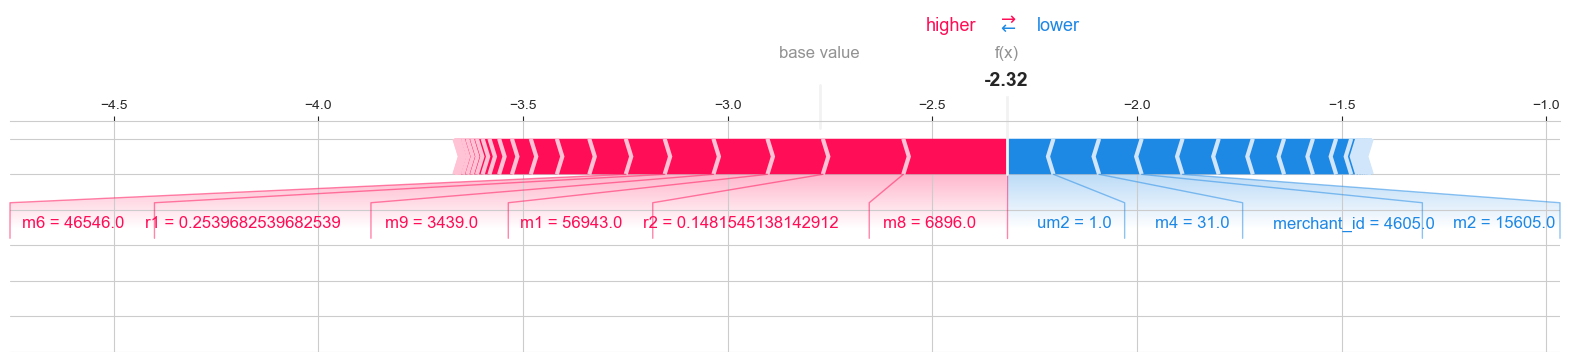

In [45]:
import shap
import matplotlib.pyplot as plt

# 1. 创建SHAP解释器
explainer = shap.TreeExplainer(model_xgb)  # 替换model为你的训练好的模型变量

# 2. 计算SHAP值（假设X_test是你的测试数据）
shap_values = explainer.shap_values(test_data)

# 3. 可视化分析
# 摘要图（显示特征重要性）
shap.summary_plot(shap_values, test_data, show=False)
plt.savefig('summary_plot.png')  # 保存为图片
plt.close()

# 条形图摘要（特征重要性排序）
shap.summary_plot(shap_values, test_data, plot_type="bar", show=False)
plt.savefig('bar_plot.png')
plt.close()

# 单个样本解释（例如第一个样本）
shap.initjs()  # 初始化JS（用于Notebook中的交互式显示）
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    test_data.iloc[0, :] if hasattr(test_data, 'iloc') else test_data[0],
    matplotlib=True  # 设置为True生成静态图
)
plt.savefig('force_plot.png')
plt.close()

# 依赖图（分析某个特征的影响）
#shap.dependence_plot("gender", shap_values, test_data, show=False)  # 替换feature_name
#plt.savefig('dependence_plot.png')
#plt.close()


D:\Programming_Software\Anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


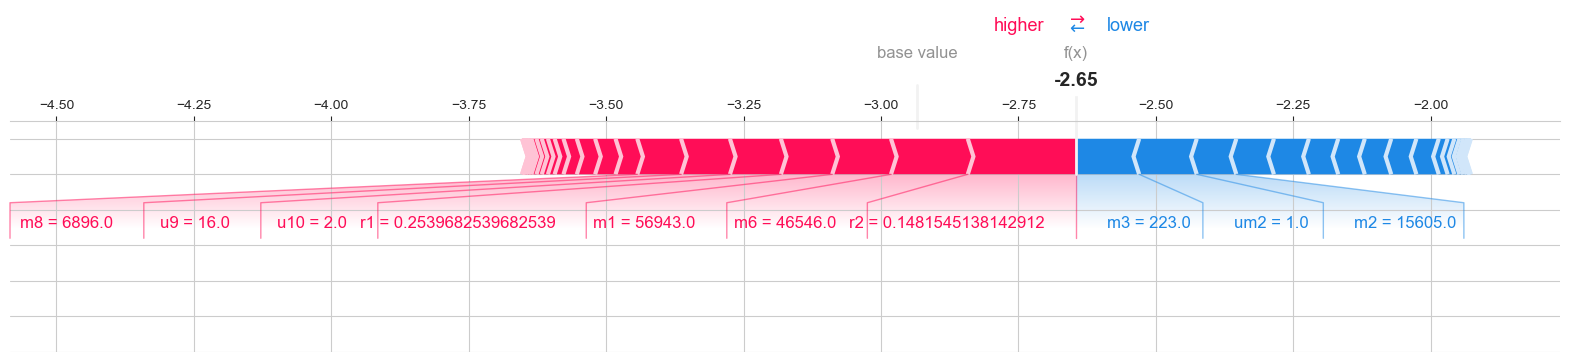

In [47]:
import shap
import matplotlib.pyplot as plt

# 1. 创建SHAP解释器
explainer = shap.TreeExplainer(model_lgb)  # 替换model为你的训练好的模型变量

# 2. 计算SHAP值（假设X_test是你的测试数据）
shap_values = explainer.shap_values(test_data)

# 3. 可视化分析
# 摘要图（显示特征重要性）
shap.summary_plot(shap_values, test_data, show=False)
plt.savefig('summary_plot.png')  # 保存为图片
plt.close()

# 条形图摘要（特征重要性排序）
shap.summary_plot(shap_values, test_data, plot_type="bar", show=False)
plt.savefig('bar_plot.png')
plt.close()

# 单个样本解释（例如第一个样本）
shap.initjs()  # 初始化JS（用于Notebook中的交互式显示）
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    test_data.iloc[0, :] if hasattr(test_data, 'iloc') else test_data[0],
    matplotlib=True  # 设置为True生成静态图
)
plt.savefig('force_plot.png')
plt.close()


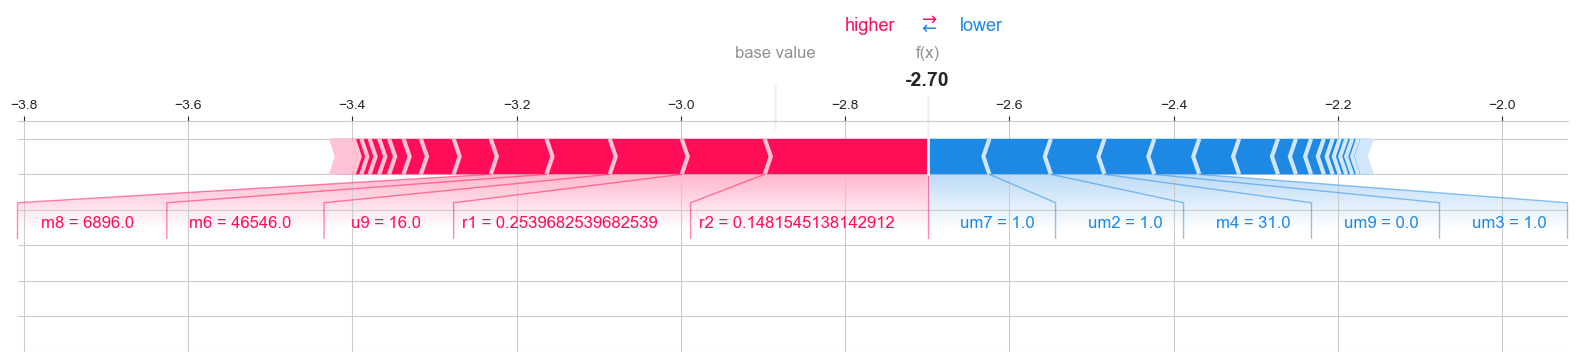

In [48]:
import shap
import matplotlib.pyplot as plt

# 1. 创建SHAP解释器
explainer = shap.TreeExplainer(model_cat)  # 替换model为你的训练好的模型变量

# 2. 计算SHAP值（假设X_test是你的测试数据）
shap_values = explainer.shap_values(test_data)

# 3. 可视化分析
# 摘要图（显示特征重要性）
shap.summary_plot(shap_values, test_data, show=False)
plt.savefig('summary_plot.png')  # 保存为图片
plt.close()

# 条形图摘要（特征重要性排序）
shap.summary_plot(shap_values, test_data, plot_type="bar", show=False)
plt.savefig('bar_plot.png')
plt.close()

# 单个样本解释（例如第一个样本）
shap.initjs()  # 初始化JS（用于Notebook中的交互式显示）
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    test_data.iloc[0, :] if hasattr(test_data, 'iloc') else test_data[0],
    matplotlib=True  # 设置为True生成静态图
)
plt.savefig('force_plot.png')
plt.close()
